In [ ]:
!pip install pyfuzzy-toolbox[ml] -q

print('✅ pyfuzzy-toolbox instalado com sucesso!')

## 📦 Importações

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import fuzzy_systems as fs
from fuzzy_systems import MamdaniSystem
from fuzzy_systems.learning import MamdaniLearning

%matplotlib inline

# Configurações
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

print('✅ Bibliotecas importadas!')
print(f'   pyfuzzy-toolbox: {fs.__version__}')

✅ Módulo de EDO Fuzzy implementado com sucesso!

Características:
  • Integração completa com fuzzy_systems.core
  • Suporte a FuzzySet, triangular, gaussiana, trapezoidal
  • Método de α-níveis vetorizado
  • Paralelização automática (joblib)
  • Condições iniciais e parâmetros fuzzy
  • Visualização de envelopes por α-nível
✅ Bibliotecas importadas!
   pyfuzzy-toolbox: 1.0.5


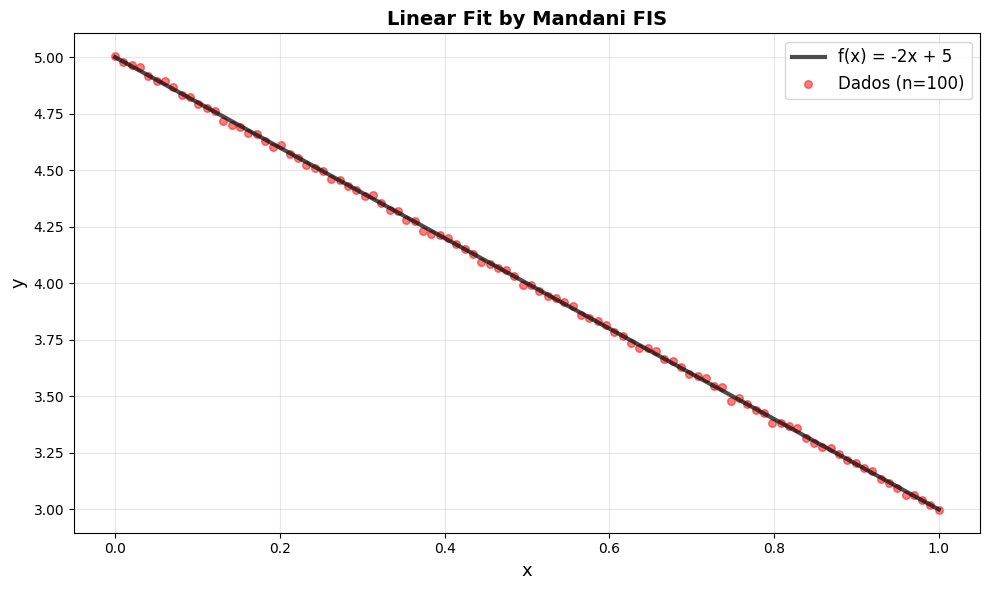

In [2]:
# Função alvo
def funcao_real(x):
    """f(x) = -2x + 5"""
    return -2 * x + 5

# Gerar dados
n_samples = 100
X_train = np.linspace(0, 1, n_samples).reshape(-1, 1)
y_train = funcao_real(X_train.flatten()) + np.random.normal(0, 0.01, n_samples)

X_test = np.linspace(0, 1, 200).reshape(-1, 1)
y_true = funcao_real(X_test.flatten())

# Visualizar
plt.figure(figsize=(10, 6))
plt.plot(X_test, y_true, 'k-', linewidth=3, label='f(x) = -2x + 5', alpha=0.7)
plt.scatter(X_train, y_train, color='red', s=30, alpha=0.5, label=f'Dados (n={n_samples})')
plt.xlabel('x', fontsize=13)
plt.ylabel('y', fontsize=13)
plt.title('Linear Fit by Mandani FIS', fontsize=14, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()


In [3]:
# ==================== 3. CRIAR SISTEMA FUZZY ====================

fis = MamdaniSystem()
input_universe = X_train.min(), X_train.max()
diff = y_train.max() - y_train.min()

output_universe = (y_train.min() - 0.1*diff, y_train.max() + 0.1*diff)

fis.add_input('x', input_universe)
fis.add_output('y', output_universe)

num_input_mfs = 7
num_output_mfs = 7

input_centers = np.linspace(input_universe[0], input_universe[1], num_input_mfs)
del_in = (input_centers[1]-input_centers[0])
for i in range(num_input_mfs):
    a =  input_centers[i] - del_in
    b =  input_centers[i]
    c =  input_centers[i] + del_in
    fis.add_term('x', f'IN_{i+1}', 'trimf', (a, b, c))     

output_centers = np.linspace(output_universe[0], output_universe[1], num_output_mfs)
del_out = (output_centers[1]-output_centers[0])
for i in range(num_output_mfs):
    a =  output_centers[i] - del_out
    b =  output_centers[i]
    c =  output_centers[i] + del_out
    fis.add_term('y', f'OUT_{i+1}', 'trimf', (a, b, c))

fis.info()


📊 INFORMAÇÕES DO SISTEMA: Mamdani FIS

🔧 Tipo: MamdaniSystem
📝 Nome: Mamdani FIS

📥 VARIÁVEIS DE ENTRADA (1):
──────────────────────────────────────────────────────────────────────
  1. 'x'
     Universo: (np.float64(0.0), np.float64(1.0))
     Termos (7): 'IN_1', 'IN_2', 'IN_3', 'IN_4', 'IN_5', 'IN_6', 'IN_7'

📤 VARIÁVEIS DE SAÍDA (1):
──────────────────────────────────────────────────────────────────────
  1. 'y'
     Universo: (np.float64(2.7969228273798623), np.float64(5.205698442816499))
     Termos (7): 'OUT_1', 'OUT_2', 'OUT_3', 'OUT_4', 'OUT_5', 'OUT_6', 'OUT_7'

📋 REGRAS:
──────────────────────────────────────────────────────────────────────
  Total: 0 regras

⚙️  CONFIGURAÇÕES:
──────────────────────────────────────────────────────────────────────
  Defuzzificação: DefuzzMethod.CENTROID

💡 EXEMPLO DE USO:
──────────────────────────────────────────────────────────────────────
  # Adicionar uma regra (sintaxe recomendada - tupla plana):
  system.add_rule('IN_1', 'OUT_1')

  # 

In [4]:
# Instace the model
learner = MamdaniLearning(fis, num_points=1000, verbose=True)

In [5]:
learner.fit_rules(
            X_train, y_train,
            optimizer='sa',
            optimizer_params={'temperature_init': 100.0, 'cooling_rate': 0.95, 'max_iterations': 5000,'temperature_min': 1e-6},
            initial_solution_method='random'
        )

y_pred_train = learner.predict(X_train)
y_pred = learner.predict(X_test)

rmse_train = learner.get_cost()
rmse_test = learner.score(X_test, y_true)


📚 MAMDANI FUZZY RULE LEARNING
Optimizer: SA

🔧 Creating efficient FIS representation:
 - Input variables: 1
 - MFs per input: [7]
 - Output MFs: 7
 - AND operator: TNorm.MIN
 - Implication: min
 - Aggregation: max
 - Defuzzification: DefuzzMethod.CENTROID
 - Total rules: 7

⚠️  Rule base is empty - creating from input combinations...
 - Terms per variable: [7]
 - Total rules to create: 7
✅ Created 7 rules

Dataset size: 100 samples

Pre-computing rule activations...
Pre-computed activations: shape (100, 7)
 - 100 samples
 - 7 rules

Initialization method: random
Simulated Annealing - Optimization
Initial cost: 0.533267
Initial temperature: 100.00
Iter    0 | T=100.00 | New best solution! Cost: 0.405958
Iter   53 | T=  6.60 | New best solution! Cost: 0.369444
Iter  100 | T=  0.56 | Current cost: 0.693260 | Best: 0.369444 | Acceptance rate: 99.0%
Iter  148 | T=  0.05 | New best solution! Cost: 0.369212
Iter  150 | T=  0.05 | New best solution! Cost: 0.284497
Iter  156 | T=  0.03 | New b

## 📈 Passo 5: Visualizar Resultados

In [ ]:
# Criar visualização
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

history = learner.get_history()

# 1. Aproximação
axes[0, 0].plot(X_test, y_true, 'b-', linewidth=3, label='Real', alpha=0.7)
axes[0, 0].plot(X_test, y_pred, 'r--', linewidth=2.5, label='FIS', alpha=0.8)
axes[0, 0].scatter(X_train, y_train, alpha=0.3, s=20, c='blue')
axes[0, 0].set_xlabel('x', fontsize=12)
axes[0, 0].set_ylabel('y', fontsize=12)
axes[0, 0].set_title(f'Aproximação\nRMSE = {rmse_test:.4f}', 
                     fontsize=13, fontweight='bold')
axes[0, 0].legend(fontsize=10)
axes[0, 0].grid(True, alpha=0.3)

# 2. Erro
error = y_pred - y_true
axes[0, 1].plot(X_test, error, 'g-', linewidth=2.5)
axes[0, 1].axhline(y=0, color='k', linestyle='--')
axes[0, 1].fill_between(X_test.flatten(), 0, error, alpha=0.3, color='green')
axes[0, 1].set_xlabel('x', fontsize=12)
axes[0, 1].set_ylabel('Erro', fontsize=12)
axes[0, 1].grid(True, alpha=0.3)

# 3. Convergência PSO
axes[1, 0].plot(history['current_cost'], linewidth=2.5, color='darkblue')
axes[1, 0].set_xlabel('Iteração', fontsize=12)
axes[1, 0].set_ylabel('Fitness (RMSE)', fontsize=12)
axes[1, 0].set_title('Convergência FIS', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)

# 4. Distribuição do Erro
axes[1, 1].hist(error, bins=30, edgecolor='black', alpha=0.7, color='green')
axes[1, 1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('Erro', fontsize=12)
axes[1, 1].set_ylabel('Frequência', fontsize=12)
axes[1, 1].set_title('Distribuição do Erro', fontsize=13, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


In [ ]:
rm = fis.plot_rule_matrix()

In [ ]:
# Configurações dos otimizadores
optimizers_config = {
    'SA': {
        'optimizer': 'sa',
        'params': {
            'temperature_init': 100.0,
            'cooling_rate': 0.95,
            'max_iterations': 2000,
            'plateau_iterations': 500,
            'temperature_min': 1e-6
        }
    },
    'GA': {
        'optimizer': 'ga',
        'params': {
            'pop_size': 50,
            'max_gen': 100,
            'mutation_rate': 0.1,
            'crossover_rate': 0.8
        }
    },
    'PSO': {
        'optimizer': 'pso',
        'params': {
            'n_particles': 30,
            'n_iterations': 100,
            'w_max': 0.9,
            'w_min': 0.4
        }
    },
    'DE': {
        'optimizer': 'de',
        'params': {
            'pop_size': 30,
            'max_iter': 100,
            'F': 0.8,
            'CR': 0.7
        }
    }
}

learner = MamdaniLearning(fis, num_points=1000, verbose=True)
optimizer ='GA'
learner.fit_rules(
            X_train, y_train,
            optimizer=optimizers_config[optimizer]['optimizer'],
            optimizer_params=optimizers_config[optimizer]['params'],
            initial_solution_method='random'
        )